# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNeXt101_32X8D_Weights.IMAGENET1K_V2
model = models.resnext101_32x8d(weights=weights)
transforms1 = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=5),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms1
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.split_ids = self.split_ids[:32]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)#/32
        #self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        num_pieces = self.num_pieces[i]

        return image, num_pieces.float()

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 32
Number of valid images: 32
Number of test images: 32


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([16, 224, 224, 3])
torch.Size([16])
tensor(1)


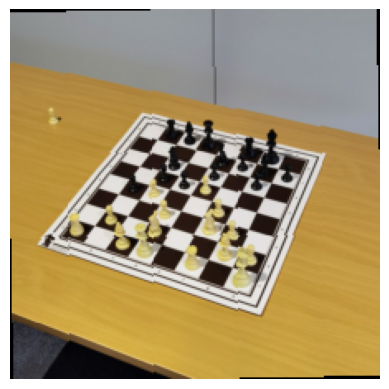

In [8]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

## Train the model

Define function to perform one iteration

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).unsqueeze(1) # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 31 + 1)#.round() # Scale [0,1] → [1,32] and round
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.extend(scaled_pred.cpu().detach().numpy())
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(y.cpu())
          #print(original_values)
    return total_loss / num_batches, mean_absolute_error(preds, labels)

Define function to train a model

In [11]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [ ]:
# Define loss function
loss_fn = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
#optimizer = torch.optim.SGD(model.parameters(), lr=5e-5, momentum=0.9)
num_epochs = 10

# TODO - Train the model
train_history, val_history = train(model, 'TestModel', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


Train loss: 219.98775 	 Train acc: 14.81186


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Val loss: 153.19439 	 Val acc: 12.23581

Epoch 2


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Train loss: 186.22174 	 Train acc: 13.62270


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Val loss: 136.18354 	 Val acc: 11.51154

Epoch 3


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


Train loss: 147.37560 	 Train acc: 12.10824


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Val loss: 120.84178 	 Val acc: 10.81413

Epoch 4


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Train loss: 111.43313 	 Train acc: 10.51570


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Val loss: 106.99744 	 Val acc: 10.14695

Epoch 5


100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


Train loss: 73.11214 	 Train acc: 8.49291


100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


Val loss: 92.23495 	 Val acc: 9.39083

Epoch 6


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Train loss: 46.29799 	 Train acc: 6.69383


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Val loss: 76.07970 	 Val acc: 8.48899

Epoch 7


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Train loss: 29.67283 	 Train acc: 5.31893


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Val loss: 59.18686 	 Val acc: 7.43505

Epoch 8


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Train loss: 14.65811 	 Train acc: 3.69487


100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


Val loss: 40.40109 	 Val acc: 6.01886

Epoch 9


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Train loss: 7.24625 	 Train acc: 2.58955


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Val loss: 25.81806 	 Val acc: 4.61266

Epoch 10


100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


Train loss: 3.62738 	 Train acc: 1.79785


100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


Val loss: 16.12645 	 Val acc: 3.41045

Epoch 11


100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


Train loss: 2.48363 	 Train acc: 1.40410


100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


Val loss: 10.39494 	 Val acc: 2.62937

Epoch 12


100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


Train loss: 1.27450 	 Train acc: 1.01367


100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Val loss: 6.26426 	 Val acc: 2.07267

Epoch 13


100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


Train loss: 0.92343 	 Train acc: 0.87004


100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Val loss: 3.86366 	 Val acc: 1.68336

Epoch 14


100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Train loss: 0.51434 	 Train acc: 0.65563


100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


Val loss: 3.05253 	 Val acc: 1.47869


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

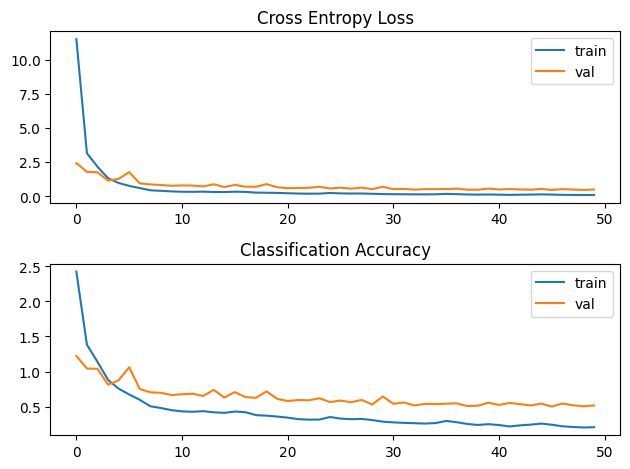

In [ ]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [ ]:
# Load the best model
# TODO
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, drop_last=False)
print(torch.load('TestModel_best_model.pth')['model'])
model = model.load_state_dict(torch.load('chess_model_best_model.pth')['model'])
# Evaluate model on test data
# TODO
def test(dataloader):
    preds = []
    labels = []
    with torch.set_grad_enabled(False):
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = pred.cpu().detach().numpy()*32
            preds.extend(predsTmp)
            #print(pred.cpu())
            #print(y.cpu())
            original_values =y.cpu()
            labels.extend(original_values)
            #print(original_values)
        return mean_absolute_error(preds, labels)
test_loss = test(test_dataloader)
print(f"mean absolute error : {test_loss:.3f}")

OrderedDict([('conv1.weight', tensor([[[[-4.6489e-02,  3.3788e-02,  1.8024e-03,  ...,  9.4316e-02,
           -3.1074e-02, -4.8674e-03],
          [-2.6333e-03,  1.5300e-01, -2.5547e-01,  ...,  2.2641e-01,
           -1.0707e-01, -1.1099e-02],
          [ 4.2620e-02, -1.6595e-01, -3.0379e-01,  ..., -2.1977e-01,
           -2.8643e-01,  7.7740e-02],
          ...,
          [-2.0959e-02,  1.0218e-01,  3.2017e-01,  ...,  4.0588e-01,
            3.8490e-01, -1.8488e-01],
          [ 2.1505e-02,  8.8872e-02, -3.6214e-01,  ...,  5.1756e-01,
           -2.7142e-01, -2.7909e-02],
          [-2.7266e-02, -1.6980e-02, -6.6909e-02,  ..., -2.2928e-02,
           -1.3404e-01,  4.9795e-02]],

         [[ 1.3167e-02, -1.7587e-03, -4.3302e-02,  ...,  1.9486e-01,
           -5.7045e-02, -5.0102e-02],
          [-1.1555e-02,  6.4698e-02, -3.4602e-01,  ...,  3.2756e-01,
           -2.4808e-01, -2.2552e-02],
          [ 3.4074e-02, -2.9581e-01, -1.7259e-01,  ..., -4.5979e-01,
           -5.4661e-01,  1.8

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "fc.0.weight", "fc.0.bias", "fc.2.weight", "fc.2.bias". 

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?